In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a partial mouse brain to the Allen Referece Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

We define the server and our user token

In [3]:
server = "dev.neurodata.io"
userToken = txtRead("/cis/project/clarity/code/ndreg/userToken.pem").strip()

First we'll download the atlas image

In [4]:
refToken = "ara3"
refImg = imgDownload(refToken, channel="average", server=server, userToken=userToken)

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [5]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

269.129411765


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

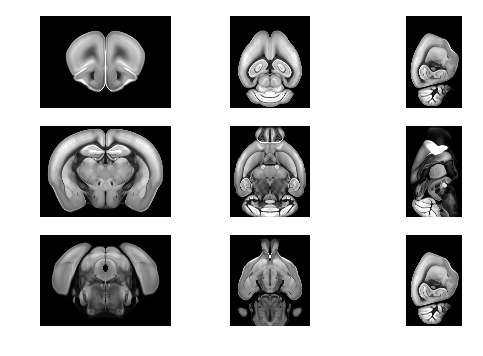

In [6]:
imgShow(refImg, vmax=refThreshold)

Now we download the corresponding annotations

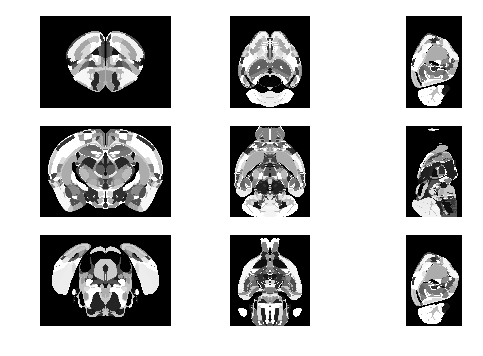

In [7]:
refAnnoImg = imgDownload(refToken, channel="annotation", server=server, userToken=userToken)
refAnnoImgOrig = refAnnoImg[:,:,:]
imgShow(refAnnoImg, vmax=1000)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [8]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

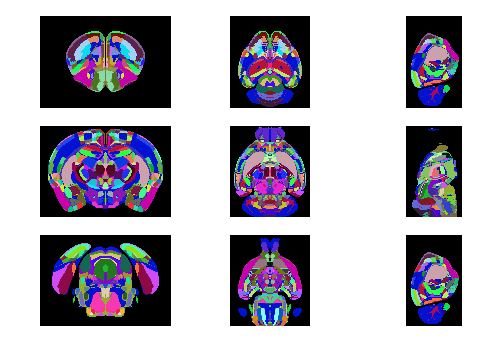

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

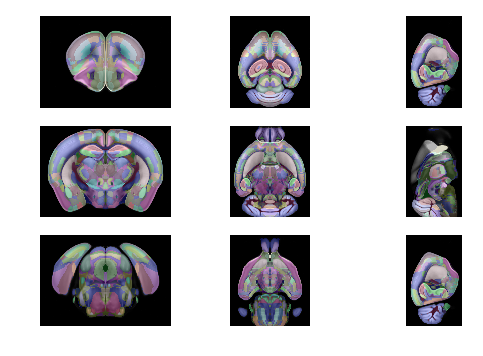

In [10]:
imgShow(refImg, vmax=refThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

## Downloading input image
*ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [11]:
inToken = "s278"
nd = neurodata(hostname="dev.neurodata.io", user_token=userToken)
print(nd.get_metadata(inToken)['dataset']['imagesize']) 

{u'10': [2, 2, 953], u'1': [824, 901, 953], u'0': [1648, 1802, 953], u'3': [206, 226, 953], u'2': [412, 451, 953], u'5': [52, 57, 953], u'4': [103, 113, 953], u'7': [13, 15, 953], u'6': [26, 29, 953], u'9': [4, 4, 953], u'8': [7, 8, 953]}


Clearly resolution 1 is a resonable resolution.  So we'll download the image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [12]:
inImg = imgDownload(inToken, resolution=1, userToken=userToken, server=server)
inImg.SetSpacing(np.array(inImg.GetSpacing())*1000) ###
inImgOrig = inImg[:,:,:]

We'll only use intensity values below the 95th percentile in the visualization.

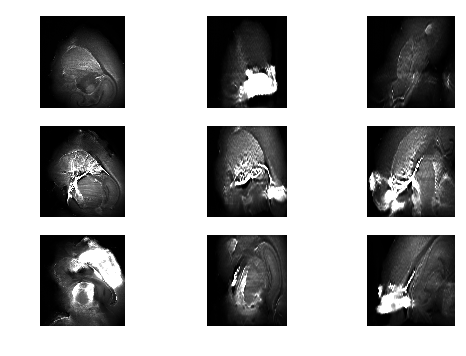

In [36]:
inImg = inImgOrig[:,:,:]
inThreshold = imgPercentile(inImg, 0.95)
imgShow(inImg, vmax=inThreshold)

## Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

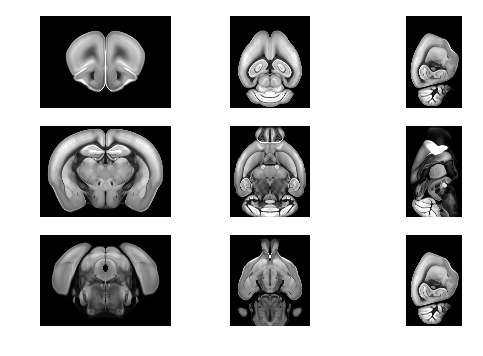

In [37]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the input brain...

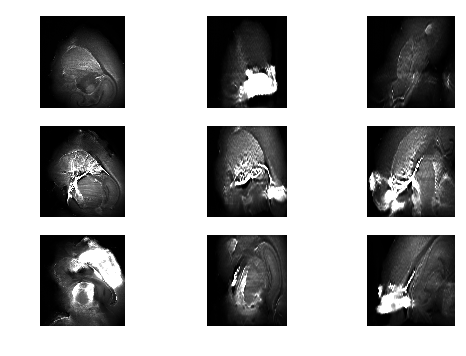

In [38]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **I**nferior to Superior, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **L**eft to Right.  Thus it's in **IAL** orientation.  Therefore we reorient the input image from **IAL** to **RSA**

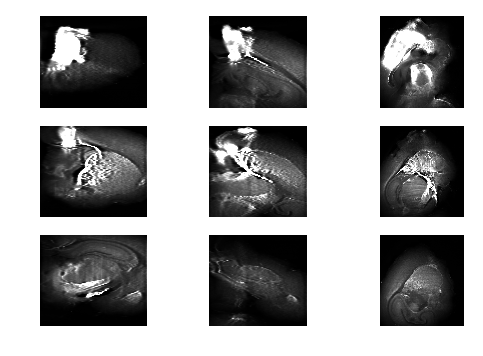

In [39]:
inOrient = "IAL"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [40]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Downample images
Now we downsample the input and reference images to a more manageable size

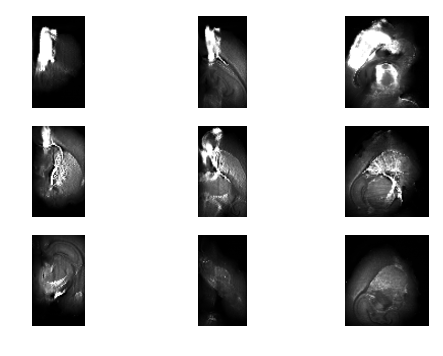

In [41]:
spacing = [0.1,0.1, 0.1]
inImg_ds = imgResample(inImg, spacing)
imgShow(inImg_ds, vmax=inThreshold)

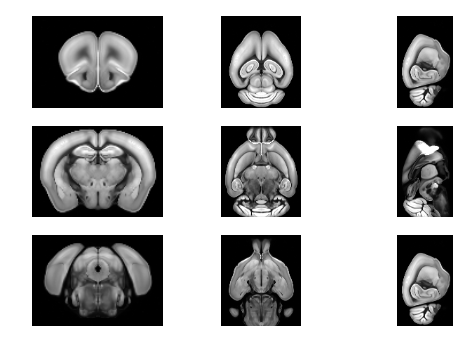

In [42]:
refImg_ds = imgResample(refImg, spacing)
imgShow(refImg_ds, vmax=refThreshold)

## Create and apply mask of reference image
Our input image only consists of part of the brain.  Therefore we mask the reference image to match the input image.  First we define a region of interest starting at the following point with the following size in mm.

In [43]:
roiStart = [5.4, 0.8, 2.1]
roiSize = [4,7,7]

We then convert these values to from mm to voxels

In [44]:
roiStartVoxel = (roiStart / np.array(spacing)).astype('uint16').tolist()
print(roiStartVoxel)
roiSizeVoxel = (roiSize / np.array(spacing)).astype('uint16').tolist()
print(roiSizeVoxel)

[54, 8, 21]
[40, 70, 70]


We create an Region Of Interest of value 255

In [45]:
roiImg = sitk.Image(roiSizeVoxel,sitk.sitkUInt8)
roiImg += 255

We then paste this into an empty image to create a mask of the reference image

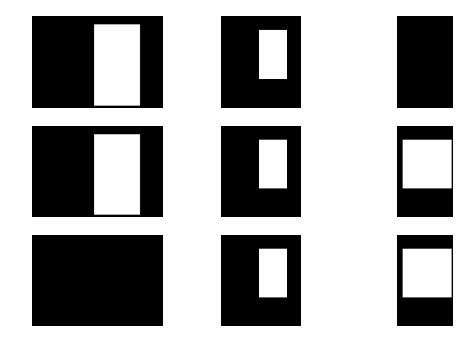

In [46]:
emptyImg = sitk.Image(refImg_ds.GetSize(),sitk.sitkUInt8) # Create an empty image
emptyImg.CopyInformation(refImg_ds) # Copy spacing, origin and direction from reference image
refMask = sitk.Paste(emptyImg, roiImg, roiSizeVoxel, [0,0,0], roiStartVoxel)
imgShow(refMask, vmax=255)

Now we apply this mask to our downsampled reference image

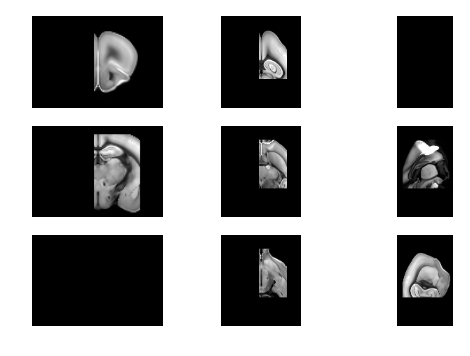

In [47]:
refImg_ds = sitk.Mask(refImg_ds, refMask)
imgShow(refImg_ds, vmax=refThreshold)

## Create input image mask
Notice how the input image has extremely bright regions. 

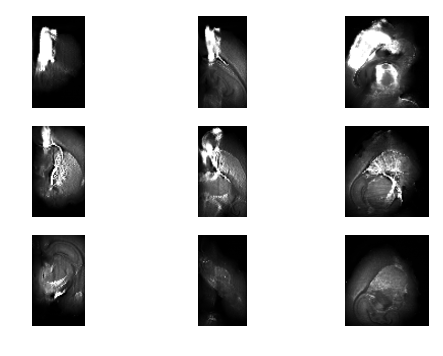

In [48]:
imgShow(inImg_ds, vmax=inThreshold)

This will likly interfere with the registration.  Therefore we create a registration mask which excludes those regions

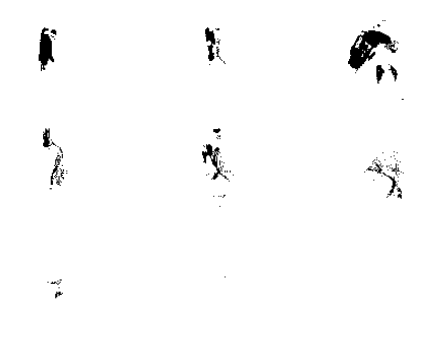

In [49]:
threshold = imgPercentile(inImg_ds,0.95)
inMask_ds = sitk.BinaryThreshold(inImg_ds, 0, threshold, 255, 0)
imgShow(inMask_ds, vmax=255)

# Affine Registration
We can finally begin the registration. We will initialize the affine registration using the reference image's region of interest

[1, 0, 0, 0, 1.2, 0, 0, 0, 1, -5.4, -0.8, -2.1]


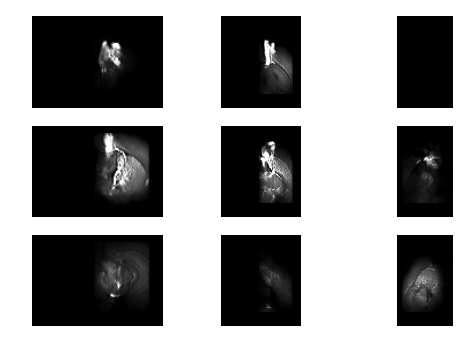

In [51]:
translation = -np.array(roiStart)
inAffine = [1,0,0,0,1.,0,0,0,1]+translation.tolist()
print(inAffine)
imgShow(imgApplyAffine(inImg_ds, inAffine, size=refImg_ds.GetSize()),vmax = inThreshold)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [52]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True, inAffine=inAffine)

Step translation:
0.	 -0.151368461829
1.	 -0.16184900975
2.	 -0.175047029288
3.	 -0.188187414414
4.	 -0.202612955543
5.	 -0.219414050012
6.	 -0.234981811409
7.	 -0.249208246687
8.	 -0.261314007959
9.	 -0.277809630469
10.	 -0.287606411186
11.	 -0.301834886079
12.	 -0.316686627179
13.	 -0.322216124555
14.	 -0.320989617439
15.	 -0.321230456776
16.	 -0.324289356139
17.	 -0.324302245822
18.	 -0.321336558506
19.	 -0.324292459781
Step scale:
0.	 -0.330032508943
1.	 -0.337494250394
2.	 -0.353060448794
3.	 -0.369153663758
4.	 -0.371629655845
5.	 -0.371109584597
6.	 -0.371276203903
7.	 -0.372088629403
Step rigid:
0.	 -0.367150905014
1.	 -0.290575497449
2.	 -0.359598293014
3.	 -0.344619281922
4.	 -0.368870534542
5.	 -0.360104714141
6.	 -0.366231080944
7.	 -0.367581713458
8.	 -0.367853065515
9.	 -0.368166812393
Step affine:
0.	 -0.389947293934
1.	 -0.337212550235
2.	 -0.395208283186
3.	 -0.42033396343
4.	 -0.424962397915
5.	 -0.429724902801
6.	 -0.430336311035
7.	 -0.432756680302
8.	 -0.4333926404

Now we apply the affine transform to the input image and mask

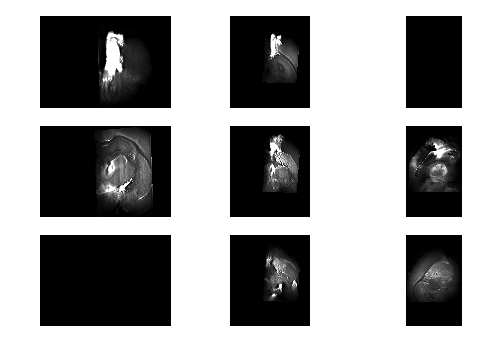

In [53]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg_affine, vmax=inThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

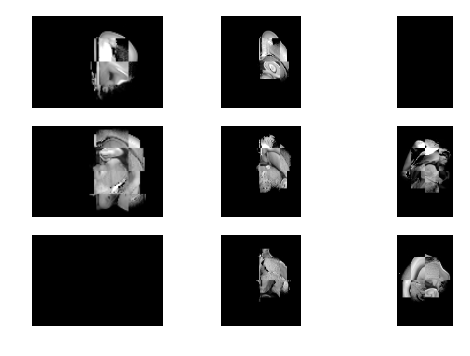

In [54]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(inImg_ds, refImg_ds), vmax=refThreshold)

We also apply the  affine to the input mask

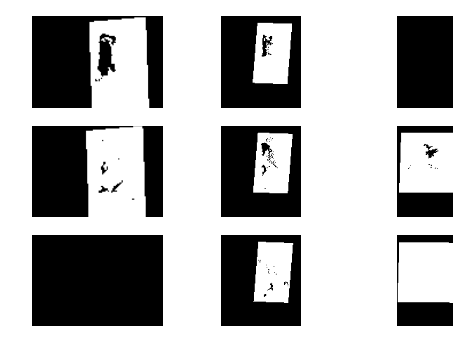

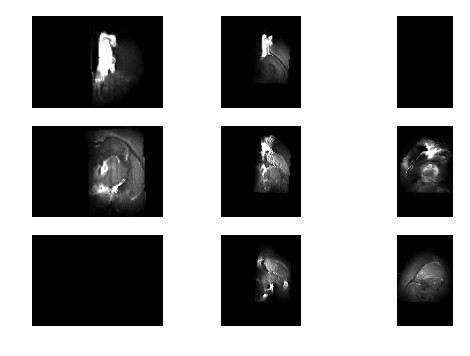

In [55]:
inMask_ds = imgApplyAffine(inMask_ds, affine, useNearest=True, size=refImg_ds.GetSize())
imgShow(inMask_ds, vmax=255)
imgShow(inImg_ds, vmax=inThreshold)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference image have very differnt intensity profiles.

In [56]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.1, 0.05,0.02],
                                              scaleList = [1.0, 1.0,1.0], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.1, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-4.95637e+09, 0.133449, 0, -4.95637e+09 (99.2423%), 1.100000e-03
1.	-5.16027e+09, 0.463248, 0, -5.16027e+09 (98.7418%), 1.210000e-03
2.	-5.37616e+09, 1.16002, 0, -5.37616e+09 (98.2119%), 1.331000e-03
3.	-5.52198e+09, 2.53973, 0, -5.52198e+09 (97.8539%), 1.464100e-03
4.	-5.57731e+09, 4.37978, 0, -5.57731e+09 (97.7181%), 1.610510e-03
5.	-5.57815e+09, 4.65726, 0, -5.57815e+09 (97.7161%), 2.214451e-04
6.	-5.57839e+09, 4.74002, 0, -5.57839e+09 (97.7155%), 6.089741e-05
7.	-5.57927e+09, 4.78565, 0, -5.57927e+09 (97.7133%), 3.349358e-05
8.	-5.5793e+09, 4.78882, 0, -5.5793e+09 (97.7132%), 2.302683e-06
9.	-5.5793e+09, 4.78882, 0, -5.5793e+09 (97.7132%), 1.545991e-10
E = -5.5793e+09 (97.7132%)
Length = 5.37152
Time = 163.961s (2.73269m)

Step 1: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-5.79252e+09, 0.322754, 0, -5.79252e+09 (99.4609%), 1.10000

Now we apply the displacement field

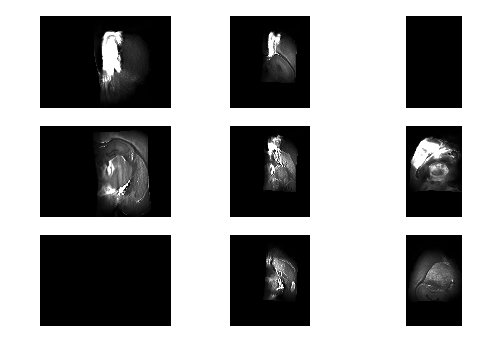

In [57]:
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
imgShow(inImg_lddmm, vmax=inThreshold)

### Evaluation LDDMM registration
Now we evaluate the deformable registration using a checkerboard image

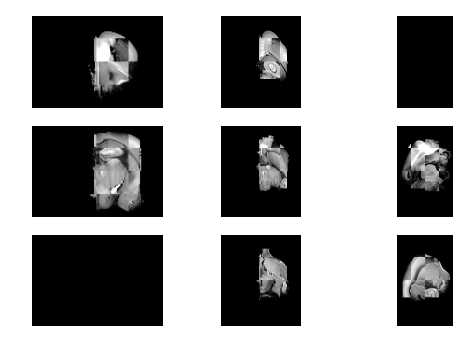

In [58]:
inImg_ds = imgResample(inImg_lddmm, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(inImg_ds, refImg_ds), vmax=refThreshold)

We can also evaluate the registration by overlaying the atlas annotations over the deformed input image.

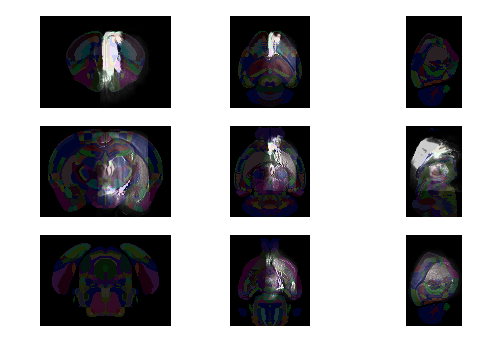

In [59]:
imgShow(inImg_lddmm, vmax=inThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Uploading Results

### Uploading deformed input image
We can now upload the atlas-aligned input brain back into ndstore.

In [60]:
outToken = inToken + "_to_" + refToken
imgUpload(inImg_lddmm, outToken, server=server, userToken=userToken)
### imgWrite(inImg_lddmm, "/cis/project/clarity/data/ailey/"+outToken+"_new.img")

### Uploading deformed atlas annotations

In [ ]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the atlas annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the reference space to the input space before registration.

In [ ]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

Were not done yet.  We still need to reorient these annotations to their original  

In [ ]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

We can upload these annotations at the lowest possible resolution.

In [ ]:
outToken = "ara3_to_AutA"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)